In [765]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [766]:
%matplotlib inline

import os
import h5py
import json
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import zscore
from scipy import stats as scipystats
from sklearn import decomposition

from utils.neurosuite import get_unit_names_sorted
from utils.behavior import get_idxs_as_periods
from utils.states import get_state_as_periods
#from utils.events import get_sound_event_periods

In [767]:
#source  = '/Users/andrey/sandbox/'
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source  = '/mnt/nevermind.data-share/ag-grothe/AG_Pecka/data/processed/'

#session = '013608_ppcSIT_2025-01-06_13-20-52'  # PPC
session = '013608_ppcSIT_2025-01-14_10-20-14'  # HPC
#session = '013608_ppcSIT_2025-01-15_14-56-18'  # HPC
#session = '013608_ppcSIT_2025-01-16_09-49-21'  # PPC
#session = '013608_ppcSIT_2025-01-20_09-38-20'  # HPC
#session = '013608_ppcSIT_2025-01-21_08-50-02'  # Thalamus
#session = '013608_ppcSIT_2025-01-22_12-59-00'  # PPC
#session = '013608_ppcSIT_2025-01-23_08-46-51'  # HPC

animal      = session.split('_')[0]
s_path = os.path.join(source, animal, session)
meta_file   = os.path.join(source, animal, session, 'meta.h5')
units_file  = os.path.join(source, animal, session, 'units.h5')
phsl_file = os.path.join(source, animal, session, 'analysis', 'sound_phase_lock.h5')

In [768]:
# reading events and spiking data
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_mx = np.array(f['processed']['target_matrix'])

spike_times = {}
with h5py.File(units_file, 'r') as f:
    unit_names = get_unit_names_sorted([name for name in f])
    for unit_name in f:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])
        
spike_times_all = spike_times.copy()

In [769]:
x_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 1]
y_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 2]
speed_ev = tl[sound_events[:, 2].astype(np.int32)][:, 3]

speed_max = 0.04
idxs_sta_ev = np.where(speed_ev < speed_max)[0]
idxs_run_ev = np.where(speed_ev > speed_max)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
idxs_di1_ev = np.where(sound_events[:, 1] == 3)[0]
idxs_di2_ev = np.where(sound_events[:, 1] == 4)[0]

# success stays
idxs_tgt_succ = []
tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
for tgt_rec in tgt_mx_succ:
    idxs_tgt_succ += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
idxs_tgt_succ = np.array(idxs_tgt_succ)

tgt_succ_pos_mx = np.zeros([len(tgt_mx_succ), 4])
for i, tgt_rec in enumerate(tgt_mx_succ):
    x_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 1]
    y_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 2]
    
    tgt_succ_pos_mx[i] = [tgt_rec[0], tgt_rec[1], x_pos.mean(), y_pos.mean()]

In [770]:
bgr_sta_long_mx, idxs_bgr_sta_long = get_state_as_periods(s_path, 'BGR', 'STA', None, 11, strip_l=0)
sil_sta_long_mx, idxs_sil_sta_long = get_state_as_periods(s_path, 'SIL', 'STA', None, 11, strip_l=0)
bgr_sta_AL_mx, idxs_bgr_sta_AL = get_state_as_periods(s_path, 'BGR', 'STA', 'AL', 12)
len(idxs_bgr_sta_long), len(idxs_sil_sta_long), len(idxs_bgr_sta_AL)

(498, 469, 421)

In [771]:
# MRL
MRL_mx = np.zeros([len(unit_names), 2])  # MRL, p-value
with h5py.File(phsl_file, 'r') as snd_f:
    for i, unit_name in enumerate(unit_names):
        MRL = np.array(snd_f['tgt'][unit_name]['MRL_real'])
        pv  = np.array(snd_f['tgt'][unit_name]['p_value'])
        MRL_mx[i] = np.array([MRL, pv])

In [772]:
# mean firing rate
FR_mx = np.zeros([len(unit_names), 2])  # MRL, mean rate, median ISI
for i, unit_id in enumerate(unit_names):
    spiketrain = spike_times[unit_id]
   
    mean_rate = len(spiketrain) / (tl[-1][0] - tl[0][0])
    
    isis = np.diff(spiketrain)
    robust_rate = 1 / np.median(isis)
    
    FR_mx[i] = np.array([mean_rate, robust_rate])

## Unit filtering

In [774]:
# special units 
special = {
    '013608_ppcSIT_2025-01-14_10-20-14': ['2-142', '2-234', '3-217', '4-198'],
    '013608_ppcSIT_2025-01-15_14-56-18': ['2-166', '2-288', '3-258', '4-231'],
    '013608_ppcSIT_2025-01-20_09-38-20': ['2-160', '2-241', '3-221', '4-201']
}

# exclude some?
#for unit in special['013608_ppcSIT_2025-01-14_10-20-14']:
#    spike_times.pop(unit)

idxs_special = [unit_names.index(x) for x in special[session]]
print(f"{len(idxs_special)} units to be excluded as special")

# MRL criteria
pv_min = 0.3
MRL_min = 0.05
MFR_min = 0.5

idxs_mfr_min = np.where(FR_mx[:, 0] > MFR_min)[0]
print(f"{len(idxs_mfr_min)} out of {len(unit_names)} units > 0.5Hz firing rate")
    
# MRL
idxs_MRL_high = np.where((MRL_mx[:, 0] > MRL_min) & (MRL_mx[:, 1] < pv_min))[0]
idxs_MRL_low  = np.where(MRL_mx[:, 0] < MRL_min)[0]

idxs_MRL_high = np.intersect1d(idxs_mfr_min, idxs_MRL_high)
idxs_MRL_high = np.setdiff1d(idxs_MRL_high, idxs_special)
idxs_MRL_low = np.intersect1d(idxs_mfr_min, idxs_MRL_low)
idxs_MRL_low = np.setdiff1d(idxs_MRL_low, idxs_special)

idxs_mfr_spc = np.setdiff1d(idxs_mfr_min, idxs_special)

idxs_final_filt = idxs_mfr_spc
spike_times = {}
unit_ids = [unit_names[x] for x in idxs_final_filt]

# or special units
unit_ids = ['2-432', '3-296', '4-338', '3-330', '3-279', '3-436', '1-107', '2-304',\
            '3-34', '3-265', '1-165', '2-478', '2-420', '4-302', '1-427', '1-459',\
            '3-127', '3-88', '4-261', '3-62', '4-51', '1-441', '2-83', '4-200', \
            '2-435', '3-332', '3-63', '3-271', '4-319', '2-28', '3-74', '3-280', \
            '1-121', '4-322', '3-389', '3-33', '1-147', '1-449', '3-76', '1-440', \
            '1-442', '1-482', '1-450', '4-90', '3-6', '4-212', '2-123', '1-139', \
            '4-262', '4-37']

for unit_id in unit_ids:
    spike_times[unit_id] = spike_times_all[unit_id]

print(f"{len(idxs_MRL_high)} units with phase locking")
print(f"{len(idxs_MRL_low)} units have kind of no phase locking")
print(f"{len(unit_ids)} units selected")

4 units to be excluded as special
156 out of 213 units > 0.5Hz firing rate
46 units with phase locking
80 units have kind of no phase locking
50 units selected


## Unit activity matrix

In [775]:
# unit activity matrix
unit_mx_database = {}

In [776]:
# OPTION 1 - sound events binning
t_bins = sound_events[:, 0]
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)

unit_mx = zscore(unit_mx, axis=1)
unit_mx_database[1] = unit_mx.T.copy()

unit_mx.shape

(50, 9599)

In [777]:
# OPTION 2 - few sound events unwrapped in the future
unwrap_count = 1  # plus one more event

t_bins = sound_events[:, 0]
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])  # units, sound events
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)
unit_mx = zscore(unit_mx, axis=1)  # sound events, units

res = unit_mx.copy()
for i in range(unwrap_count):
    res = np.vstack([res, np.roll(unit_mx, -i-1)])  # should be - ?

unit_mx_database[2] = res.T.copy()

unit_mx.shape, res.shape

((50, 9599), (100, 9599))

## Corrs within the state

### TGT success

In [778]:
# select which unit activity matrix
unit_mx = unit_mx_database[1]

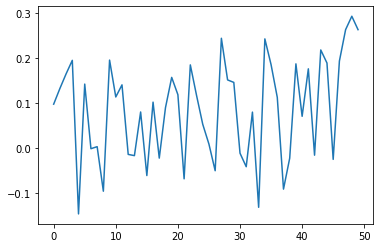

In [779]:
# PCA on TGT success only
unit_mx_tgt = unit_mx[idxs_tgt_succ]
ev_pca = decomposition.PCA(n_components=2)
ev_X   = ev_pca.fit_transform(unit_mx_tgt)
plt.plot(ev_pca.components_[0])

In [780]:
# vector selection
#sel_mx = bgr_sta_long_mx
#sel_mx = sil_sta_long_mx
#sel_mx = bgr_sta_AL_mx
sel_mx = tgt_succ_pos_mx

In [781]:
pca_eigen = ev_pca.components_[0]  # set to 1 to avoid
corr_medians = []
pulses_rel = [x for x in range(-15, 40)]
#pulses_rel = [x for x in range(0, 24)]
corr_tgt_mx = []
for rel_pulse_idx in pulses_rel:
    combs = list(itertools.combinations(range(len(sel_mx)), 2))  # combinations of vector IDs

    for idx_1, idx_2 in combs:
        v1 = unit_mx[int(sel_mx[idx_1][0]) + rel_pulse_idx] #* pca_eigen
        v2 = unit_mx[int(sel_mx[idx_2][0]) + rel_pulse_idx] #* pca_eigen

        corr = np.corrcoef(v1, v2)[0][1]
        dist = np.sqrt( (sel_mx[idx_1][2] - sel_mx[idx_2][2])**2 + (sel_mx[idx_1][3] - sel_mx[idx_2][3])**2 )
        time = np.abs(sel_mx[idx_2][0] - sel_mx[idx_1][0]) / 4  # in seconds
            
        # pulse id rel to target onset, corr coeff, dist b/w targets, time b/w targets
        corr_tgt_mx.append(np.array([rel_pulse_idx, corr, dist, time]))
corr_tgt_mx = np.array(corr_tgt_mx)

In [782]:
def get_corr_stats(corrs):
    mean = np.mean(corrs)
    med  = np.median(corrs)
    std  = np.std(corrs)
    stde = scipystats.sem(corrs)

    j_min, j_max = scipystats.t.interval(0.95, len(corrs)-1, loc=np.median(corrs), scale=scipystats.sem(corrs))
    
    return [mean, med, std, stde, j_min, j_max]

In [788]:
# TODO: do sliding window and / or bootstrapping to build a smooth curve
rel_pulse_ids = np.unique(corr_tgt_mx[:, 0])

bin_count, overlap = 11, 1
dist_bins = np.linspace(0, corr_tgt_mx[:, 2].max(), bin_count)
time_bins = np.linspace(0, corr_tgt_mx[:, 3].max(), bin_count)
dist_bw = dist_bins[1] - dist_bins[0]
time_bw = time_bins[1] - time_bins[0]

# matrix: rel pulse id, dist or time, means, medians, stds, stde, intervals
corr_dist_mean_mx = []
corr_time_mean_mx = []
for r, rel_pulse_idx in enumerate(rel_pulse_ids):
    for i in range(len(dist_bins) - 1):
        idxs_rel_pulse = np.where(corr_tgt_mx[:, 0] == rel_pulse_idx)[0]
        idxs_dist = np.where((corr_tgt_mx[:, 2] > dist_bins[i]) & (corr_tgt_mx[:, 2] < dist_bins[i] + overlap*dist_bw))[0]
        idxs_time = np.where((corr_tgt_mx[:, 3] > time_bins[i]) & (corr_tgt_mx[:, 3] < time_bins[i] + overlap*time_bw))[0]

        corrs_dist = corr_tgt_mx[np.intersect1d(idxs_rel_pulse, idxs_dist)][:, 1]
        corrs_time = corr_tgt_mx[np.intersect1d(idxs_rel_pulse, idxs_time)][:, 1]

        corr_dist_mean_mx.append([rel_pulse_idx, dist_bins[i+1]] + get_corr_stats(corrs_dist))
        corr_time_mean_mx.append([rel_pulse_idx, time_bins[i+1]] + get_corr_stats(corrs_time))

        if dist_bins[i] + 3*dist_bw > corr_tgt_mx[:, 2].max():
            break
        
corr_dist_mean_mx = np.array(corr_dist_mean_mx)
corr_time_mean_mx = np.array(corr_time_mean_mx)

-0.16948235318599017
-3.8250071574795774e-05


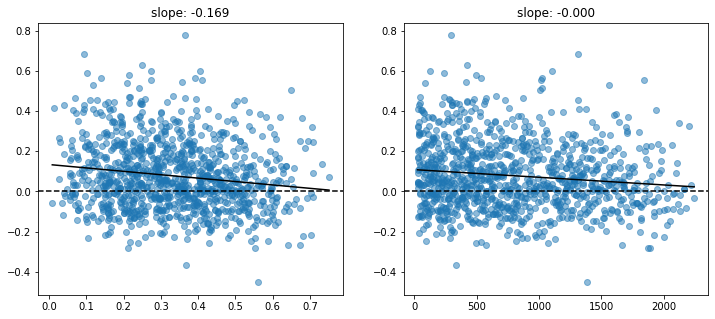

In [807]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

mx_sel = corr_tgt_mx[corr_tgt_mx[:, 0] == 10]

for i, ax in enumerate(axes):
    x = mx_sel[:, i+2]
    y = mx_sel[:, 1]
    
    #x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))  # MinMax 
    #y_scaled = (y - np.min(y)) / (np.max(y) - np.min(y))  # MinMax 
    lr_res = scipystats.linregress(x, y)
    sl, it = lr_res.slope, lr_res.intercept
    print(sl)
    
    ax.plot([x.min(), x.max()], [x.min()*sl + it, x.max()*sl + it], color='black')
    
    ax.scatter(mx_sel[:, i+2], mx_sel[:, 1], alpha=0.5)
    ax.axhline(0, ls='--', color='black')
    ax.set_title(f'slope: {sl:.3f}')

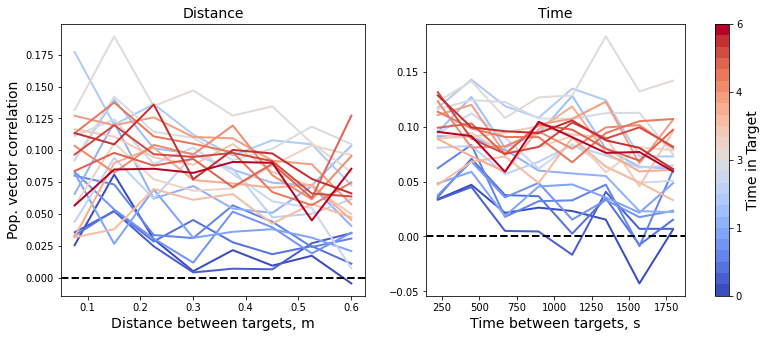

In [790]:
cmap = cm.get_cmap('coolwarm')
#offsets = np.unique(corr_dist_mean_mx[:, 0])
offsets = np.arange(0, 24)
colors = [cmap(i) for i in np.linspace(0, 1, len(offsets))]
lr_dist_mx = np.zeros([len(offsets), 4])
lr_time_mx = np.zeros([len(offsets), 4])
max_dist = 0.75  # larger distances are very noisy
max_time = 2500  # larger times are very noisy

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
for i, rel_pulse in enumerate(offsets):
    idxs_pulse = np.where(corr_dist_mean_mx[:, 0] == rel_pulse)[0]
    x_vals = corr_dist_mean_mx[idxs_pulse][:-1, 1]  # exclude last bin - too much variance
    y_vals = corr_dist_mean_mx[idxs_pulse][:-1, 2]  # exclude last bin - too much variance
    ax.plot(x_vals, y_vals, lw=2, color=colors[i])
    #ax.scatter(corr_tgt_mx[:, 2], corr_tgt_mx[:, 1])
    ax.set_xlabel('Distance between targets, m', fontsize=14)
    ax.set_ylabel('Pop. vector correlation', fontsize=14)
    ax.set_title('Distance', fontsize=14)
    
    # linregress
    idxs_pulse     = np.where(corr_tgt_mx[:, 0] == rel_pulse)[0]
    idxs_dist_filt = np.where(corr_tgt_mx[:, 2] < max_dist)[0]
    x = corr_tgt_mx[np.intersect1d(idxs_pulse, idxs_dist_filt)][:, 2]
    y = corr_tgt_mx[np.intersect1d(idxs_pulse, idxs_dist_filt)][:, 1]
    x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))  # MinMax 
    y_scaled = (y - np.min(y)) / (np.max(y) - np.min(y))  # MinMax 
    lr_res = scipystats.linregress(x_scaled, y_scaled)
    #lr_res = scipystats.linregress(x, y)
    lr_dist_mx[i] = np.array([rel_pulse, lr_res.slope, lr_res.intercept, lr_res.pvalue])
    
    #sl, it = lr_res.slope, lr_res.intercept
    #print(sl, it)
    #ax.plot([x.min(), x.max()], [x.min()*sl + it, x.max()*sl + it], color=colors[i])

ax = axes[1]
for i, rel_pulse in enumerate(offsets):
    idxs_pulse = np.where(corr_time_mean_mx[:, 0] == rel_pulse)[0]
    x_vals = corr_time_mean_mx[idxs_pulse][:-1, 1]  # exclude last bin - too much variance
    y_vals = corr_time_mean_mx[idxs_pulse][:-1, 2]  # exclude last bin - too much variance
    ax.plot(x_vals, y_vals, lw=2, color=colors[i])
    ax.set_xlabel('Time between targets, s', fontsize=14)
    ax.set_title('Time', fontsize=14)
    
    # linregress - exclude last bins!
    idxs_pulse     = np.where(corr_tgt_mx[:, 0] == rel_pulse)[0]
    idxs_time_filt = np.where(corr_tgt_mx[:, 3] < max_time)[0]
    x = corr_tgt_mx[np.intersect1d(idxs_pulse, idxs_time_filt)][:, 3]
    y = corr_tgt_mx[np.intersect1d(idxs_pulse, idxs_time_filt)][:, 1]
    x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))  # MinMax 
    y_scaled = (y - np.min(y)) / (np.max(y) - np.min(y))  # MinMax 
    lr_res = scipystats.linregress(x_scaled, y_scaled)
    lr_time_mx[i] = np.array([rel_pulse, lr_res.slope, lr_res.intercept, lr_res.pvalue])

listed_cmap = mcolors.ListedColormap(colors)
norm = mcolors.Normalize(vmin=0, vmax=len(colors))
sm = cm.ScalarMappable(cmap=listed_cmap, norm=norm)
sm.set_array([])  # Required for matplotlib < 3.1
cbar = plt.colorbar(sm, ax=axes[1], orientation='vertical', fraction=0.05, pad=0.1)
cbar.set_label("Time in Target", fontsize=14)

tick_positions = np.linspace(0, len(colors), num=5)
tick_labels = [f"{int(i/4)}" for i in tick_positions]
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)

for ax in axes:
    ax.axhline(0, lw=2, ls='--', color='black')
    #ax.set_ylim(-0.05, 0.15)

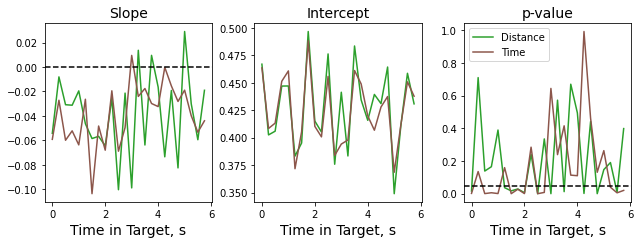

In [791]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))

clr_dist = '#2ca02c'
clr_time = '#8c564b'
time_vals = np.arange(len(lr_dist_mx))/4

# slopes
ax = axes[0]
ax.plot(time_vals, lr_dist_mx[:, 1], color=clr_dist)
ax.plot(time_vals, lr_time_mx[:, 1], color=clr_time)
ax.axhline(0, ls='--', color='black')
ax.set_title('Slope', fontsize=14)

ax = axes[1]
ax.plot(time_vals, lr_dist_mx[:, 2], color=clr_dist)
ax.plot(time_vals, lr_time_mx[:, 2], color=clr_time)
ax.set_title('Intercept', fontsize=14)

ax = axes[2]
ax.plot(time_vals, lr_dist_mx[:, 3], label='Distance', color=clr_dist)
ax.plot(time_vals, lr_time_mx[:, 3], label='Time', color=clr_time)
ax.set_title('p-value', fontsize=14)
ax.axhline(0.05, ls='--', color='black')
ax.legend()
#ax.set_yscale('log')

for ax in axes:
    ax.set_xlabel('Time in Target, s', fontsize=14)

fig.tight_layout()

## Long stays to TGT success

In [739]:
#mx1 = tgt_succ_pos_mx
mx1 = bgr_sta_long_mx
mx2 = sil_sta_long_mx
#mx2 = tgt_succ_pos_mx

In [754]:
pulses_rel = [x for x in range(-15, 20)]

combs = list(itertools.product(range(len(mx1)), range(len(mx2))))
corr_tgt_bgr_sta_mx = []
for rel_pulse_idx in pulses_rel:
    for idx_1, idx_2 in combs:
        v1 = unit_mx[int(mx1[idx_1][0]) + rel_pulse_idx] #* pca_eigen
        v2 = unit_mx[int(mx2[idx_2][0]) + rel_pulse_idx] #* pca_eigen

        corr = np.corrcoef(v1, v2)[0][1]
        dist = np.sqrt( (mx1[idx_1][2] - mx2[idx_2][2])**2 + \
                       (mx1[idx_1][3] - mx2[idx_2][3])**2 )
        time = np.abs(mx2[idx_2][0] - mx1[idx_1][0]) / 4  # in seconds
            
        # pulse id rel to target onset, corr coeff, dist b/w targets, time b/w targets
        corr_tgt_bgr_sta_mx.append(np.array([rel_pulse_idx, corr, dist, time]))
corr_tgt_bgr_sta_mx = np.array(corr_tgt_bgr_sta_mx)

-0.047780356133823615
-1.2992665162928523e-05


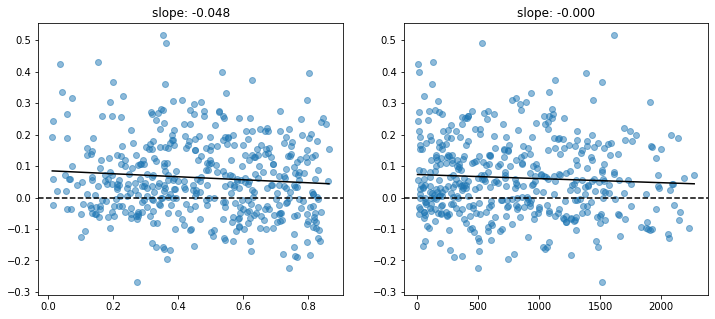

In [764]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

mx_sel = corr_tgt_bgr_sta_mx[corr_tgt_bgr_sta_mx[:, 0] == 10]
mx_sel = mx_sel[mx_sel[:, 1] < 0.9]

for i, ax in enumerate(axes):
    x = mx_sel[:, i+2]
    y = mx_sel[:, 1]
    
    #x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))  # MinMax 
    #y_scaled = (y - np.min(y)) / (np.max(y) - np.min(y))  # MinMax 
    lr_res = scipystats.linregress(x, y)
    sl, it = lr_res.slope, lr_res.intercept
    print(sl)
    
    ax.plot([x.min(), x.max()], [x.min()*sl + it, x.max()*sl + it], color='black')
    
    ax.scatter(mx_sel[:, i+2], mx_sel[:, 1], alpha=0.5)
    ax.axhline(0, ls='--', color='black')
    ax.set_title(f'slope: {sl:.3f}')

## UMAP on TGT succ

draw time in TGT by color coolwarm